In [3]:
#基本模型
import torch
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


In [4]:
# 引包
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

parser = argparse.ArgumentParser(description='Pytorch CIFAR-10 Training')
parser.add_argument('--outf', default='./model/',help='folder to output images and model checkpoints')
args = parser.parse_args(args=[])

In [6]:
EPOCH = 100 
pre_epoch = 0 
BATCH_SIZE = 128     
LR = 0.01   

In [7]:
# data augmentation
transform_train = transforms.Compose([
    # torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),                                  
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [8]:
# download data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [9]:

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2) #modify
# tags of Cifar-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [10]:
# create model
net = project1_model().to(device)

In [11]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()  
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4) #优化方式为mini-batch momentum-SGD，并采用L2正则化（权重衰减）

In [12]:

if not os.path.exists(args.outf):
  os.makedirs(args.outf)
best_acc = 85
print("Start Training")

Start Training


In [13]:
train_loss_history = []
test_loss_history = []
for epoch in range(pre_epoch, EPOCH):
  # if epoch>100:
  #   LR=0.001
  print("Epoch: %d" % (epoch+1))    
  net.train()
  sum_loss=0.0
  test_loss=0.0
  correct = 0.0
  total = 0.0
  for i, data in enumerate(trainloader, 0):
    length = len(trainloader)
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    #  train_loss
    sum_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).cpu().sum()
    # print('[epoch: %d, iter: %d] Loss: %.03f | Acc: %.03f%%' % (epoch+1, (i+1+epoch*length), sum_loss/(i+1),100. * correct/total))
  for i, data in enumerate(testloader):
    with torch.no_grad():
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      predicted_output = net(inputs)
      fit = criterion(predicted_output,labels)
      test_loss += fit.item()
      
  train_loss = sum_loss/len(trainloader)
  test_loss = test_loss/len(testloader)
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  print('Epoch %s, Train loss %s, Test loss %s'%(epoch, train_loss, test_loss))
  # check the test acc every epoch
  print("Waiting Test")
  with torch.no_grad():
    correct = 0
    total = 0
    for data in testloader:
      net.eval()
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum()
    
    acc = 100. * correct/total
    print("Testing Acc: %.3f%%" % acc)

        # save model
print('Saving Model')
  # torch.save(net.state.dict(), '%s/net_%03d.pth' % (args.outf, epoch+1))
torch.save(net, 'net.pt')
   

Epoch: 1
Epoch 0, Train loss 1.4635742628360953, Test loss 1.1524679170379155
Waiting Test
Testing Acc: 59.050%
Epoch: 2
Epoch 1, Train loss 0.9659628136383603, Test loss 0.8423491731474672
Waiting Test
Testing Acc: 71.290%
Epoch: 3
Epoch 2, Train loss 0.7533961557366354, Test loss 0.7421273385422139
Waiting Test
Testing Acc: 75.300%
Epoch: 4
Epoch 3, Train loss 0.6423703411503521, Test loss 0.6516739748701265
Waiting Test
Testing Acc: 78.380%
Epoch: 5
Epoch 4, Train loss 0.5747200144678736, Test loss 0.602431980869438
Waiting Test
Testing Acc: 79.770%
Epoch: 6
Epoch 5, Train loss 0.5230819505193959, Test loss 0.5503506916987745
Waiting Test
Testing Acc: 80.950%
Epoch: 7
Epoch 6, Train loss 0.473850188581535, Test loss 0.5130382406560681
Waiting Test
Testing Acc: 83.140%
Epoch: 8
Epoch 7, Train loss 0.44450584111158803, Test loss 0.5102563470224791
Waiting Test
Testing Acc: 83.250%
Epoch: 9
Epoch 8, Train loss 0.4150424441870521, Test loss 0.5096196747278865
Waiting Test
Testing Acc: 8

2797610


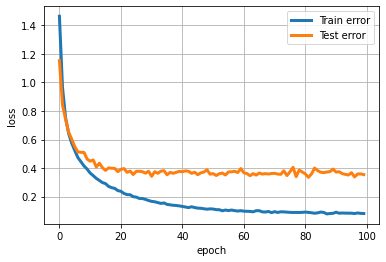

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
plt.plot(range(100),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(100),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(pytorch_total_params)

In [15]:
#model_dict=torch.load('/content/project1_model.pt')
#model_dict=model.load_state_dict(torch.load('project1_model.pt'))
#sum_s = 0

#for item in model_dict.items():
#  sum_s+=item[1].numel()

#total = sum(item[1].numel() for item in model_dict.items())
#print(total)


In [16]:
# check the trainable parameters
model_dict=torch.load('/content/net.pt')
total = sum(p.numel() for p in model_dict.parameters() if p.requires_grad)
total

2797610

In [17]:
from google.colab import files
files.download('net.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>